# Convolutional Neural Network
Here, we will use CNN to run image classification on pnemonia data.

## Import
---
Importing necessary packages and data

In [205]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

from PIL import Image
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras import models, layers, optimizers
from keras.callbacks import ModelCheckpoint

import pickle

import os
import gc
from timeit import default_timer as timer

### Image Directories

In [206]:
train_dir = 'DATA/train'
test_dir = 'DATA/test'
val_dir = 'DATA/validation'

In [207]:
# remove unnecessary variables clogging memory
def clean_up(vars_):
    for var in vars_:
        del var 
    print(gc.collect())

## Preprocess
---
We use Keras' ImageDataGenerator to resize the data. All pixel values are normalized to be between 0 - 1.

In [209]:
train_g = image.ImageDataGenerator(rescale = 1/255).flow_from_directory(train_dir,
                                                                  target_size = (150,150), 
                                                                  color_mode='grayscale',
                                                                  class_mode='binary')
val_g = image.ImageDataGenerator(rescale = 1/255).flow_from_directory(val_dir,
                                                                target_size = (150,150), 
                                                                color_mode='grayscale',
                                                                class_mode='binary')
test_g = image.ImageDataGenerator(rescale = 1/255).flow_from_directory(test_dir,
                                                                target_size = (150,150), 
                                                                color_mode='grayscale',
                                                                class_mode='binary', shuffle=False)


Found 4043 images belonging to 2 classes.
Found 1010 images belonging to 2 classes.
Found 586 images belonging to 2 classes.


### Evaluation Metrics
Since we don't want to miss any true pneumonia case, we would prioritize the recall score. But our dataset is also skewed towards the positive class (more observation of pneumonia than normal) so by chance the recall score may not capture model's performance well enough. So we will also use accuracy and aim for both high accuracy and recall.

## Baseline Model
---
We will start with an intentionally overfitting baseline model and work from there.

In [6]:
# model fit
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [7]:
# compiling models
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy', 'Recall'])

In [ ]:
# training
start = timer()

history = model.fit(train_g, 
                    epochs=100, 
                    validation_data=val_g, 
                    workers = 7
                   )

end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

In [218]:
#model = models.load_model('MODEL/baseline_model_2.h5')

In [ ]:
model.evaluate(test_g, workers = 8, verbose = 2)
# loss: 3.7529 - accuracy: 0.8328 - recall_21: 0.9943

In [15]:
# saving model
#model.save('MODEL/basline_model_2.h5')

(Lost the plots here) Based on the plot, it seems like around 16-18 is ideal number of epoch for the current model. As expected with the highly overfit model, the performance was pretty poor. Additionally the validation loss plateaus too soon. This will benefit from having more data. So we will implement data augmentation. But before that, I want to address 2 foundational issues first.  
1. Test different optimizer  
2. Test balancing the class weight as our data is slightly imbalance.  

## Optimizer
Here, we will test the Adam optimizer.

In [ ]:
# model fit
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# compiling models
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy', 'Recall'])

# training
start = timer()

history = model.fit(train_g, 
                    epochs=20, 
                    validation_data=val_g, 
                    workers = 8
                   )

end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

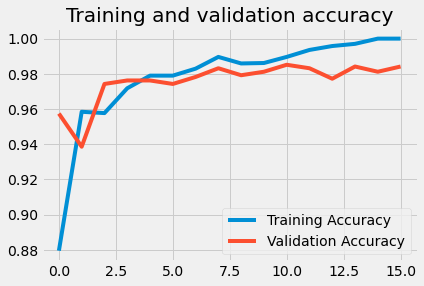

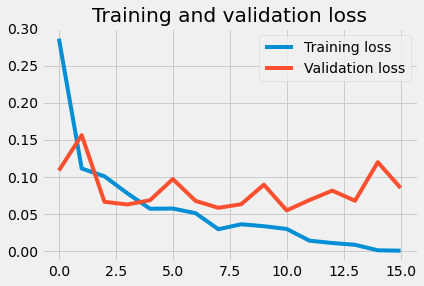

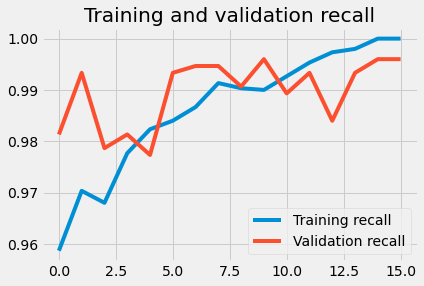

In [77]:
plot_performance(model.history)

It seems like Adams optimizer indeed converged much sooner than RMSprop. We will use Adams going forward.

## Balanced Class Weight
Now we will also check if balancing class weight for our vanilla model helps.

In [19]:
# find the weight
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', [0, 1], train_g.classes)
weights = dict(zip([0, 1], weights))

D:\ProgramData\Anaconda3\envs\workspace-gpu\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0, 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [ ]:
# model fit
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# compiling models
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy', 'Recall'])

# training
start = timer()

history = model.fit(train_g, 
                    epochs=15, 
                    class_weight=weights,
                    validation_data=val_g, 
                    workers = 8
                   )

end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

model.save('MODEL/balanced_weight.h5')

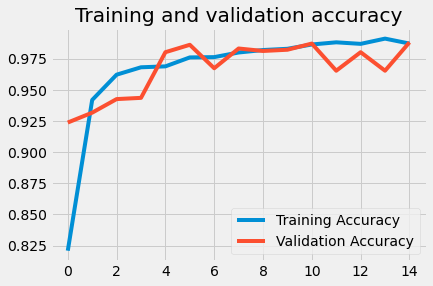

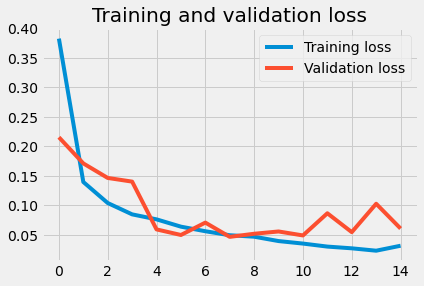

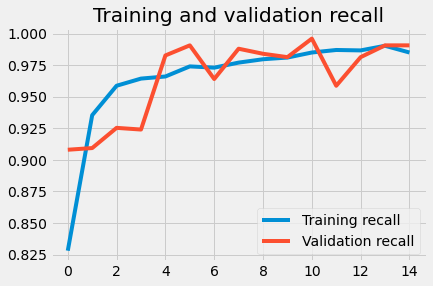

In [21]:
plot_performance(history)

In [220]:
#model = models.load_model('MODEL/balanced_weight.h5')

In [ ]:
model.evaluate(test_g, workers = 8, verbose = 2)
# loss: 0.8893 - accuracy: 0.8703 - recall_22: 0.9858

It seems like balanced class weight is slightly lowering validation loss.

## Data Augmentation
---
Now we will try adding more data with some variations.

### Model 1 
First we will include width, height, brightness and zoom into our augmented data set.

In [96]:
data_aug_train = image.ImageDataGenerator(rescale = 1/255,
                                   width_shift_range = 0.1, 
                                   height_shift_range = 0.1,
                                   brightness_range = [0.7, 1.0],
                                   zoom_range = 0.1)

train_g2 = data_aug_train.flow_from_directory(train_dir,
                                              target_size = (150,150), 
                                              color_mode='grayscale',
                                              class_mode='binary')

Found 4043 images belonging to 2 classes.


In [ ]:
# model fit
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# compiling models
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy', 'Recall'])

# training
start = timer()

history = model.fit(train_g2, 
                    epochs=60, 
                    validation_data=val_g, 
                    workers = 8
                   )

end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

In [ ]:
plot_performance(model.history)

In [113]:
# saving model
model.save('MODEL/model1.h5')

In [222]:
#model = models.load_model('MODEL/model1.h5')

In [ ]:
model.evaluate(test_g, workers = 8, verbose = 2)
# loss: 0.5625 - accuracy: 0.9181 - recall_23: 0.9830

Adding audmented data helped out model. But the validation loss was consistently lower than training loss. This is probably because the data augmentation is resulting in data that is more difficult to figure out. Additionally training loss seemed to converge much slowly. 

### Model 2 
This time we will decrease the complexity of the network and reduce the data augmentation criteria to make sure that the training problem is not unreasonably difficult.

In [ ]:
data_aug_train2 = image.ImageDataGenerator(rescale = 1/255,
                                   brightness_range = [0.7, 1.0],
                                   zoom_range = 0.1)

train_g3 = data_aug_train2.flow_from_directory(train_dir,
                                              target_size = (150,150), 
                                              color_mode='grayscale',
                                              class_mode='binary')

# model fit
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# compiling models
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(amsgrad = True),
              metrics=['accuracy', 'Recall'])

# training
start = timer()

history = model.fit(train_g3, 
                    epochs=50, 
                    validation_data=val_g, 
                    workers = 8
                   )

end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

# saving model
model.save('MODEL/model2.h5')

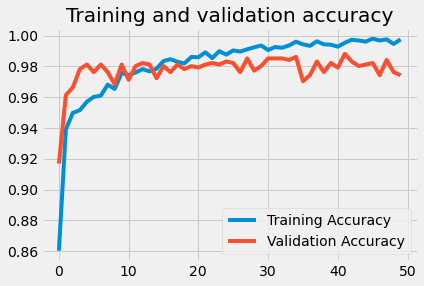

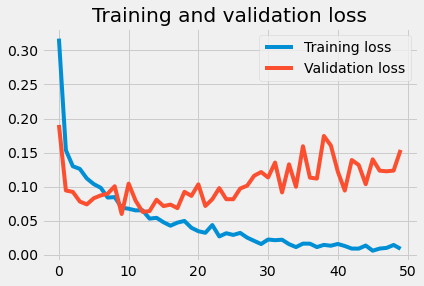

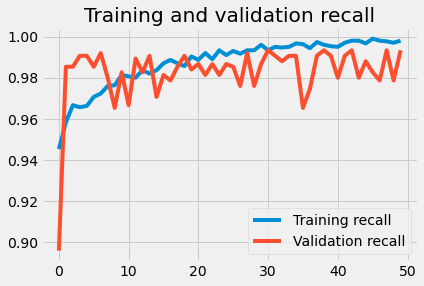

In [130]:
plot_performance(model.history)

In [225]:
#model = models.load_model('MODEL/model2.h5')

In [ ]:
model.evaluate(test_g, workers = 8, verbose = 2)
# loss: 1.2424 - accuracy: 0.8771 - recall_24: 0.9972

It seems like the validation performance is plateauing at around epoch 10-12. Let's try to see the performance with less epochs.

In [ ]:
# model fit
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# compiling models
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(amsgrad = True),
              metrics=['accuracy', 'Recall'])

# training
start = timer()

history = model.fit(train_g3, 
                    epochs=12, 
                    validation_data=val_g, 
                    workers = 8
                   )

end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

# saving model
model.save('MODEL/model2b.h5')

In [227]:
#model = models.load_model('MODEL/model2b.h5')

In [ ]:
model.evaluate(test_g, workers = 8, verbose = 2)
# loss: 0.5914 - accuracy: 0.9010 - recall_25: 0.9972

Performance is not any better. Testing errors are consistently much higher than validation. This could be because they have different distribution or sampling involved. We should try to add more generalizability. We'll try adding different, more relevant augmentation.

### Model 3
---
In a hope to increase validation accuracy, we'll try to increase the existing augmentation range slightly and add rotation.

In [6]:
# try adding slight rotation
data_aug_train3 = image.ImageDataGenerator(rescale = 1/255,
                                           brightness_range = [0.6, 1.0],
                                           rotation_range = 10,
                                           zoom_range = 0.2)

train_g4 = data_aug_train3.flow_from_directory(train_dir,
                                              target_size = (150,150), 
                                              color_mode='grayscale',
                                              class_mode='binary')



Found 4043 images belonging to 2 classes.


In [ ]:
# model fit
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# compiling models
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(amsgrad = True),
              metrics=['accuracy', 'Recall'])

# training
start = timer()

history = model.fit(train_g4, 
                    epochs=30, 
                    validation_data=val_g, 
                    workers = 8
                   )

end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

# saving model
model.save('MODEL/model3.h5')


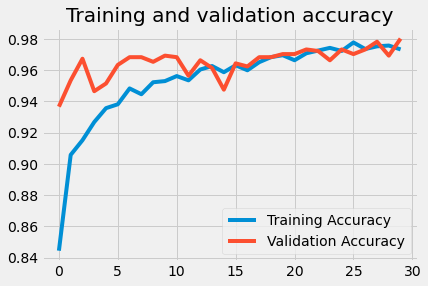

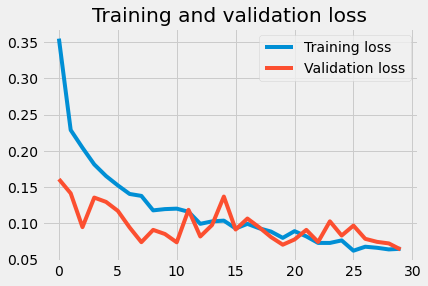

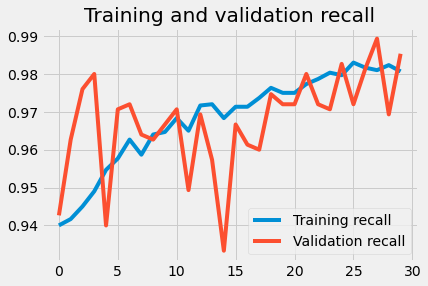

In [157]:
plot_performance(model.history)

In [229]:
model = models.load_model('MODEL/model3.h5')

In [ ]:
model.evaluate(test_g, workers = 8, verbose = 2)
# loss: 0.3485 - accuracy: 0.9249 - recall_26: 0.9915

This is definitely an improvement, validation and training errors seem to be converging together. Maybe we can add a bit more complexity in the model, since training loss also seems to be plateauing. 

## Model 4
---
We will try to add some more units towards the later layers.

In [ ]:
# model fit
model = models.Sequential()
model.add(layers.Conv2D(32, 3, padding = 'same', activation = 'relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, padding = 'same', activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, 3, padding = 'same', activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# compiling models
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(amsgrad = True),
              metrics=['accuracy', 'Recall'])

# training
start = timer()

history = model.fit(train_g4, 
                    epochs=50, 
                    validation_data=val_g, 
                    workers = 8
                   )

end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

# saving model
model.save('MODEL/model4.h5')


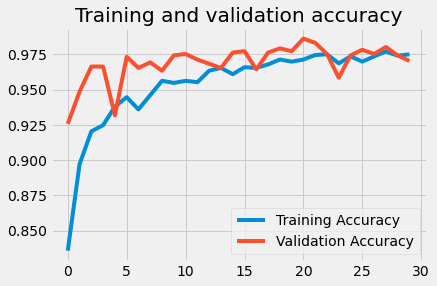

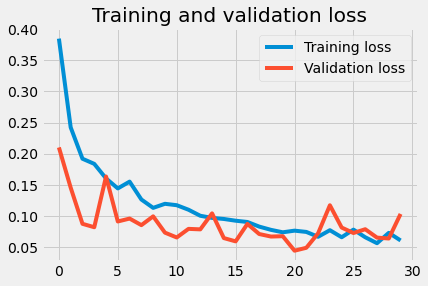

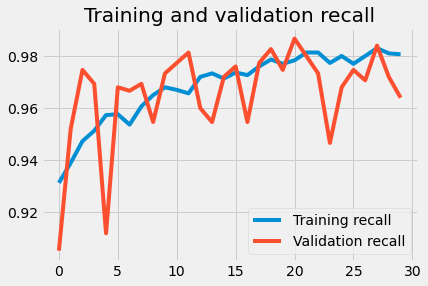

In [168]:
plot_performance(model.history)

In [231]:
#model = models.load_model('MODEL/model4.h5')

In [ ]:
model.evaluate(test_g, workers = 8, verbose = 2)
# loss: 0.2512 - accuracy: 0.9488 - recall_27: 0.9716

Much better.

#### Model 4b
We will try to add a bit more rotation, which seemed to have helped. Also we'll try to increase the input size to fine tune details even more.

In [189]:
# try adding slight rotation
data_aug_train4 = image.ImageDataGenerator(rescale = 1/255,
                                           brightness_range = [0.6, 1.0],
                                           rotation_range = 25,
                                           zoom_range = 0.2)

train_g5 = data_aug_train4.flow_from_directory(train_dir,
                                              target_size = (200,200), 
                                              color_mode='grayscale',
                                              class_mode='binary')
val_g2 = image.ImageDataGenerator(rescale = 1/255).flow_from_directory(val_dir,
                                                                target_size = (200,200), 
                                                                color_mode='grayscale',
                                                                class_mode='binary')

Found 4043 images belonging to 2 classes.
Found 1010 images belonging to 2 classes.


In [187]:
test_g_lg = image.ImageDataGenerator(rescale = 1/255).flow_from_directory(test_dir,
                                                                target_size = (200,200), 
                                                                color_mode='grayscale',
                                                                class_mode='binary', shuffle=False)

Found 586 images belonging to 2 classes.


In [243]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# model fit
model = models.Sequential()
model.add(layers.Conv2D(32, 3, padding = 'same', activation = 'relu', input_shape=(200,200, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, padding = 'same', activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, 3, padding = 'same', activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# compiling models
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(amsgrad = True),
              metrics=['accuracy', 'Recall'])

#cp = EarlyStopping(patience = 3, restore_best_weights=True)
cp = ModelCheckpoint('MODEL/model4e.h5', monitor = 'val_loss', verbose = 1, save_best_only = True)

# training
start = timer()

history = model.fit(train_g5, 
                    epochs=60, 
                    validation_data=val_g2, 
                    workers = 8, 
                    callbacks = [cp],

                   )

end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

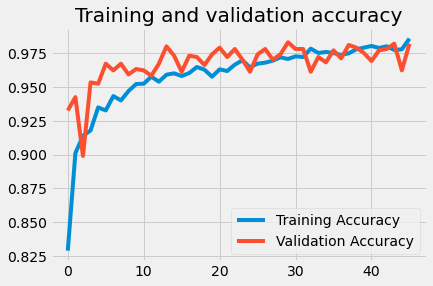

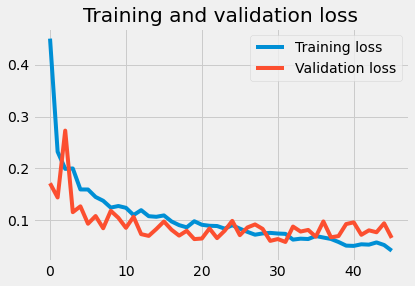

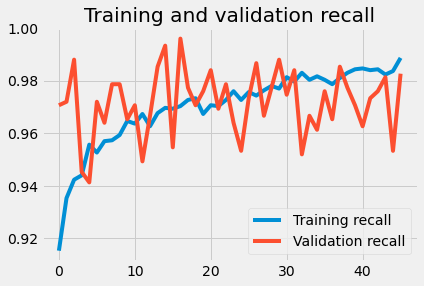

In [185]:
plot_performance(model.history)

In [241]:
model = models.load_model('MODEL/model4b.h5')

In [ ]:
model.evaluate(test_g_lg, workers = 8, verbose = 2)
# 4b- loss: 0.2336 - accuracy: 0.9471 - recall_28: 0.9716

That didn't quite improve. The validation accuracy and training accuracy seem to be plateauing at around similar rate though. Let's try some different approach.

## Model 5
---
We'll try increasing overall units across all layers except input layer to see how it affects the performance.

In [ ]:
# model fit
model = models.Sequential()
model.add(layers.Conv2D(32, 3, padding = 'same', activation = 'relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, padding = 'same', activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, 3, padding = 'same', activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# compiling models
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(amsgrad = True),
              metrics=['accuracy', 'Recall'])

# training
start = timer()

history = model.fit(train_g4,
                    initial_epoch = 20,
                    epochs=50, 
                    validation_data=val_g, 
                    workers = 8, 
                    verbose = 1
                   )

end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

# saving model
#model.save('MODEL/model5b.h5')

In [248]:
#model = models.load_model('MODEL/model5.h5')

In [ ]:
model.evaluate(test_g, workers = 8, verbose = 2)
# loss: 2.3184 - accuracy: 0.8942 - recall_31: 0.9574

Starts with high validation error but it seems to show not much learning pattern of validation across epochs.

## Model 6
---
We wanted to also try implementing batch normalization.

In [ ]:
# model fit
model = models.Sequential()
model.add(layers.Conv2D(64, 3, activation = 'relu', input_shape=(150, 150, 1)))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, 3, activation = 'relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, 3, activation = 'relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# compiling models
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy', 'Recall'])

# training
start = timer()

history = model.fit(train_g, 
                    epochs=10, 
                    validation_data=val_g, 
                    workers = 7
                   )

end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

In [ ]:
model.evaluate(test_g, workers = 8, verbose = 2)
#loss: 9.6262 - accuracy: 0.6075 - recall: 1.0000

Batch normalization didn't generalize too well to our test data.

## Model 7
---
We will see if adding a pretrained network helps.

In [ ]:
from keras.applications import VGG16

train_g = image.ImageDataGenerator(rescale = 1/255).flow_from_directory(train_dir,
                                                                  target_size = (150,150), 
                                                                  color_mode='rgb',
                                                                  class_mode='binary')
val_g = image.ImageDataGenerator(rescale = 1/255).flow_from_directory(val_dir,
                                                                target_size = (150,150), 
                                                                color_mode='rgb',
                                                                class_mode='binary')
cnn_base = VGG16(weights='imagenet', 
                 include_top=False, 
                 input_shape=(150, 150, 3))

In [ ]:
model.add(cnn_base)
model.add(layers.Flatten())
model.add(layers.Dense(132, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# compiling models
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(amsgrad = True),
              metrics=['accuracy', 'Recall'])
# training
start = timer()
history = model.fit(train_g, 
                    epochs=10, 
                    validation_data=val_g, 
                    workers = 7
                   )
end = timer()
elapsed = end - start
print('Total Time Elapsed: ', int(elapsed//60), ' minutes ', (round(elapsed%60)), ' seconds')

In [ ]:
test_g = image.ImageDataGenerator(rescale = 1/255).flow_from_directory(test_dir,
                                                                target_size = (150,150), 
                                                                color_mode='rgb',
                                                                class_mode='binary')
model.evaluate(test_g, verbose=1)
#loss: 0.9057 - accuracy: 0.7952 - recall: 0.9915

A pretrained network didn't perform as well as we hoped. It might be because the pretrained network is optimized for color images.

# Review
---
Our final model is model4 with .95 accuracy. Let's see where this model failed.

In [251]:
model = models.load_model('MODEL/model4.h5')

## Visualizing Where Model Failed
Using a model with 95% accuracy, we'll take a look at where our model failed.

ImageDataGenerator is not returning correct indices for prediction, even after setting shuffling to False, so instead we'll iterate through each file and figure out the prediction. This is possible because test set is relatively small (< 600)

In [254]:
test_g0 = image.ImageDataGenerator(rescale = 1/255)

def get_pred(path):
    filelist = os.listdir(path)
    result = {}

    for fn in filelist:
        image_ = image.load_img(f'{path}/{fn}', 
                                target_size = (150,150), 
                                color_mode='grayscale')
        input_ = np.array([image.img_to_array(image_)])
        input_f = test_g0.flow(input_)
        result[fn] = int(np.where(model.predict(input_f)[0] > 0.5, 1, 0))
    return result

In [255]:
Neg_class_preds = get_pred('DATA/test/normal')
Pos_class_preds = get_pred('DATA/test/pneumonia')

In [256]:
FP_list = [k for k, v in Neg_class_preds.items() if v != 0]
FN_list = [k for k, v in Pos_class_preds.items() if v != 1]

### Confusion Matrix

In [257]:
# getting numbers for confusion matrix
FP = len(FP_list)
FN = len(FN_list)
TP = len(Neg_class_preds) - FP
TN = len(Pos_class_preds) - FN

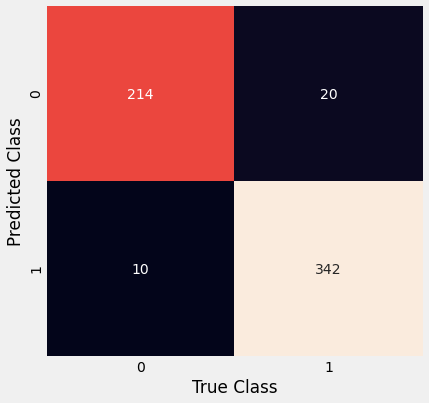

In [258]:
import seaborn as sns
cm = [[TP, FP], [FN, TN]]
plt.figure(figsize = (6, 6))
sns.heatmap(cm, annot=True, fmt="d", cbar = False)
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.show()

### Sample Wrong Predictions

In [261]:
def plot_img(path, title):
    fn = image.load_img(path, color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(title)
    plt.axis('off')
    plt.show()

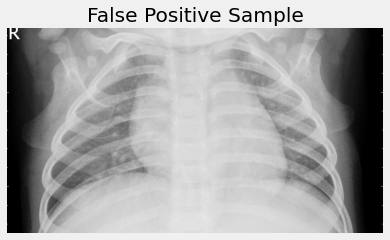

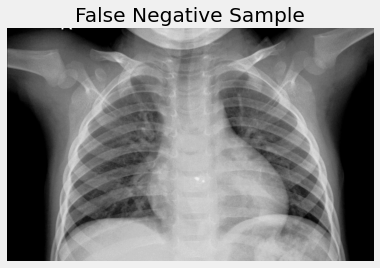

In [272]:
plot_img(f'DATA/test/normal/{np.random.choice(FP_list, 1)[0]}', 'False Positive Sample')
plot_img(f'DATA/test/pneumonia/{np.random.choice(FN_list, 1)[0]}', 'False Negative Sample')

It seems like the model is missing high contrast pneumonia cases and low contrast normal cases. For the future, possibly training at more fine grain pixels may help.